# Determining True Rating of Yelp Restaurants

Through data science analysis we aim to provide insight about the "true" rating of a restaurant on Yelp. We define the "true" rating to be the rating that a restaurant will converge to over time based upon various features of the restaurant we have scraped from Yelp through web-based scraping with BeatifulSoup. We used the full data science pipeline, beginning with data collection, then data processing, then data exploration and visualization, then finally data analysis with the use of Machine Learning techniques through the sklearn library. 


There has been previous work on making use of the Yelp dataset for interesting analytics. Most of the high quality work is documented through the Yelp Data Challenge, which provides cash prizes for the best research papers using data from Yelp. Most previous research in the area of predicting the review of a restaurant seems to be primarily based on Natural Language Processing techniques on the text of the reviews, alongside other information received from the Yelp API. Rather than focusing on text, we wanted to see if we could make these predictions off of features included in all restaurants, even those with very few reviews, as a way to be able to predict the “true” rating of the restaurant. Therefore, we had to look for features outside of the Yelp API, specifically getting many features from the “More Business Info” section found on the each Yelp restaurant page through manual web scraping. Features used within our model focus on the business info provided by a restaurant, an example can be seen here from https://www.yelp.com/biz/gaucho-parrilla-argentina-pittsburgh?osq=Restaurants&search_key=54684

![Feature Example](https://i.imgur.com/EFe4a2B.png)

We feel that answering this question will be particularly useful for new restaurants with few ratings that are curious as to what their true rating will be over time given features about their restaurant that they already can know without many reviews. 

## Imports

We used various libraries for this project, which are all included in the imports section below. 

In [72]:
import requests
from bs4 import BeautifulSoup
import cPickle as pickle
import matplotlib.pyplot as plt
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
import folium
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import Counter
import sklearn.cross_validation as cv
import random
import numpy as np
from copy import deepcopy
from collections import Counter

## Data Collection

We collected the dataset we will analyze with the use of the Yelp API and Beautiful Soup. We also used the python library Pickle to serialize our dataset so we don't have to continuously query the Yelp API to retrieve our data set. 

We first used the Yelp API to scrape at most 1000 restaurants (because of limitations of the Yelp API) from the top 280 cities in America (stored in cities.txt) by population. We created functions for basic functionalities such as saving a pickle file, loading a pickle file, authenticating on Yelp, getting all restaurant info, getting all restaurants in a city, getting a list of all the top 280 cities, grabbing the relevant fields from each restaurant, cleaning the data, and finally a function to grab all the data using all the functions just described. 

Due to the limitations set by the Yelp API, there were significant challenges in both the data collection and data cleaning portions of this project. One example of these challenges is that the Yelp API returns a significant amount of unnecessary data making collection very slow. Efforts were made in allowing for interruption of the data collection, from either system shutdown, or yelp service interruption. Additionally, we needed to make a second pass requesting the HTML for each url provided by the API to gain access to important features available only through the website. All data is collected, cleaned, and stored in python Pickle objects to reduce load on Yelp, as well as reduce time to load data into memory. We queried and scraped the Yelp website periodically to retrieve a sufficient amount of data points without getting limited for making too many http requests.

The code used for our data collection can be seen in the appendix at the end of the notebook. 

## Data Processing

To use the classification tools within scikit learn we had to transform and map the features we obtained from Yelp to inputs matching that of the API of the library. The data we collected from Yelp, in particular, the business info was a wide assortment of string based values and Yelp class objects. For instance, the feature Wifi can take string values such as yes, no, free, paid, etc. Since a lot of these string features were mainly binary and discrete values over a small range we created a mapping to transform these values into integers. To do so, we discovered the set of all possible values of each feature and mapped each one to a unique integer value within the context of that feature. Similarly with Yelp class objects we were able to create a directed one-to-one mapping to integers to which we transformed the dataset. Discrete integer valued features were simply kept the same. Through this system we were able to adapt the features we collected to be directly compatible with the classification library. 

During the above process we decided to exclude some of the gathered features because of apparent subjectivity through open ended responses. What we found was that for these certain text based features the number of possible values they could take varied greatly and did not provide much discernable insight between restuarants. A strong example of this is the way parking is described in many different ways: valet, street, validated, private lot, garage, etc. Each of which could appear multiple times in different combinations for a single restaurant. Since transforming these features to discrete values would provide poor insight as to the rating of the restaurant, we decided to discard them. Another issue was that since we were operating with sometimes partial data from restaurants we had found some of the features we gathered to be missing (None valued). To deal with this we simply created a separate discrete valued bin to group these values into. The intuition behind this being that the absence of data could also provide insight about the restaurant's quality.

In [7]:
data = load_pickle("random.pkl")

# Input is a list of dictionarys mapping features to values (defined in pickle) 
def transform_to_XY(info):
    X = []
    Y = []
    feature_names = [i for i in info[0].keys()]
    total_vals = {}
    for x in feature_names:
        total_vals[x] = set()
    
    to_ignore = set(['name', 'rating', 'location', 'categories', 'url', 'parking', 'Best Nights','Good For'])
    
    for res in info:
        for k,v in res.items():
            if k not in to_ignore: # Some features are of list type or already floats, or not primitive types
                total_vals[k].add(v)
                
    feature_value_map = {}
    for k,v in total_vals.items():
        z = 0
        feature_value_map[k] = {}
        for value in v:
            feature_value_map[k][value] = z
            z += 1
            
    features = copy.deepcopy(info)
    nones = []
    for b in features:
        b["nones"] = sum([1 if b[f] == None else 0 for f in b])
        nones.append(44 - b["nones"])
        for f in to_ignore:
            b.pop(f, None)
        for f in b:
            if f not in to_ignore and f in feature_value_map and b[f] in feature_value_map[f]:
                if f not in ["review_count",'number_of_images']:
                    b[f] = feature_value_map[f][b[f]]
    features = [[d[f] for f in sorted(d.keys())] for d in features]
    return (features, [f["rating"]*2 for f in info], nones)

transformed = transform_to_XY(data)

## Data Exploration and Visualization

Our final data set has a total of 6308 restaurants that were randomly sampled from our much larger data set of restaurants from each of the top 280 cities in the United States.

We will now explore and visualize this dataset.

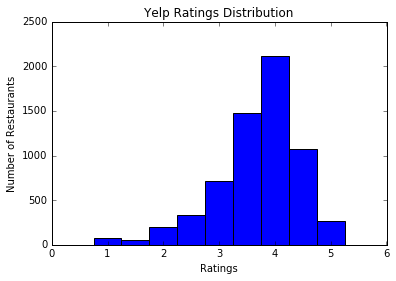

In [22]:
%matplotlib inline
        
ratings = Counter(map(lambda x : x ["rating"], data))
rating_numbers = sorted(ratings)
rating_counts = []
for i in xrange(len(rating_numbers)):
    rating_counts.append(ratings[rating_numbers[i]])
plt.bar(rating_numbers, rating_counts, 0.5, color="blue", align = "center")
plt.xlabel("Ratings")
plt.ylabel("Number of Restaurants")
plt.title("Yelp Ratings Distribution")
plt.show()

We will first explore the distribution of the variable we are trying to predict, Yelp Rating. The distribution of the Yelp Ratings in our data set is centered around 4 stars, with a slight leftward skew. The mean of the Yelp Rating is 3.7. The standard deviation of the Yelp Rating is 0.76. The minimum is 1 and the maximum is 5. We have data for each possible bucket in half star increments, for a total of 10 possible buckets. This distribution results in a strong prior, which we took note of when performing our data analysis in the next section.

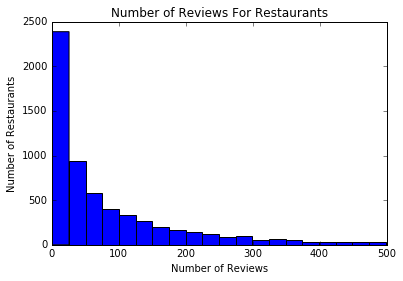

In [37]:
number_of_reviews = []
for i in xrange(len(data)):
    if (data[i]["review_count"] <= 500):
        number_of_reviews.append(data[i]["review_count"])
plt.hist(number_of_reviews, 20)
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Restaurants")
plt.title("Number of Reviews For Restaurants")
plt.show()

The distribution for the number of reviews is heavily skewed toward the right. It is so heavily skewed toward the right, we only visualized those restaurants with less than 500 reviews, as otherwise the visualization was difficult to interpret due to the length of the tail. The mean number of reviews is 121.8 reviews. The standard deviation of reviews is 247.9 reviews. The min is 1 review. The max is 4455 reviews. When performing our analysis, we should be aware that the restaurants with little reviews is much noisier data and should be considered being filtered out when training our model as the we are not certain as to whether the labels are truly accurate. 

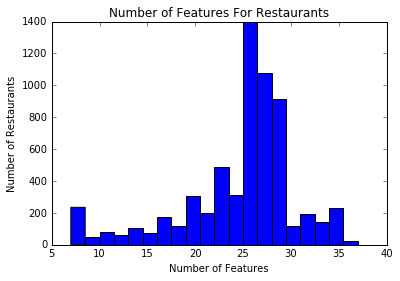

In [42]:
plt.hist(transformed[2], 20)
plt.xlabel("Number of Features")
plt.ylabel("Number of Restaurants")
plt.title("Number of Features For Restaurants")
plt.show()

Since we scraped primarily from the more business info section, as shown above, we had to deal with missing data from the “More Business Info” section which we scraped many of our features from, but before performing data analysis, we wanted to get a sense of how complete our dataset is. Therefore, we graphed the distribution of the number of features for each restaurant. The distribution is centered around 26 features. The mean is 24.4 features. The standard deviation is 6 features. The min is 7 features. The max is 37 features. Although the number of features varies decently by restaurant, overall, we still have enough features to model. 

In [8]:
locations = []
for i in xrange(len(data)):
    if data[i]["location"] != None and data[i]["location"].coordinate != None:
        locations.append((data[i]["location"].coordinate.__dict__["latitude"], 
                          data[i]["location"].coordinate.__dict__["longitude"]))

USMap = folium.Map(location=[39.8282, -98.5795], zoom_start = 4)
for location in locations:
    latitude = float(location[0])
    longitude = float(location[1])
    folium.CircleMarker(location=[latitude, longitude], radius=10, color='#3186cc', fill_color='#3186cc').add_to(USMap)
USMap.save("locations.html")

![Map](https://i.imgur.com/j89NyPC.png)

In [86]:
%%HTML
<iframe width="100%" height ="500" src="locations.html"/>

Finally, we plotted every restaurant of our data set on a map to get a sense of how they are distributed geographically. We were pleased to find that our restaurants in our data set had a good geographic distribution across the country, including Hawaii and Alaska.

## Data Analysis

In [75]:
def baseline(data):
    (X, y) = transform_to_XY(data)[:2]
    c = Counter(y)
    vals = [[x, c[x]/float(len(y))] for x in c]
    for i in range(1,len(vals)):
        vals[i][1] += vals[i-1][1]
    rands = []
    for x in range(len(y)):
        r = random.random()
        i = 0
        while r > vals[i][1]:
            i += 1
        rands.append(vals[i][0])

    wrong = 0
    dist = 0
    for (p,l) in zip(rands,y):
        if int(p) != l:
            wrong += 1
            dist += abs(l-p)/2.0
    print "correct predictions: %f%%"%((len(y)-wrong)/float(len(y)))
    print "average error: %f"%(dist/wrong)

def cross_val(model, folds):
    (X, y) = transform_to_XY(infotrain)[:2]
    pca = PCA(n_components='mle')
    pca.fit(X)
    X = pca.transform(X)
    scores = cv.cross_val_score(model,X,y, cv = folds)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [69]:
infotrain = filter(lambda x: x["review_count"] > 10, data)
model = RandomForestClassifier(n_estimators=100)
baseline(infotrain)
cross_val(RandomForestClassifier(n_estimators=100), folds = 5)

correct predictions: 0.257430%
average error: 0.844742
Accuracy: 0.41 (+/- 0.08)


To classify the ratings of the the restaurants from our data we looked into performing classification with support vector machines (SVM) with various kernels, Logistic Regression, and random forest decision trees. In particular we favored SVM because we believed that our data would be relatively closely clustered between ratings where a sigmoid kernel would perform optimally. Decision Trees through random forest also seemed promising because a lot of our features are binary and in the event of our data being non-linear we could still perform classification well. Lastly we use logistic regression because it is a good baseline approach, which performs nicely if the data is linear. Prior to using these models we also performed Principal Component Analysis (PCA) upon our data set to transform useful features and discard uninsightful features. For instance, the availability of bike parking may not have much influence over the average rating of a restaurant. Keeping these features with low correlation would add noise to our classification so we went on to only include features occurring in the principal components. Lastly we filtered out data points with less than 10 reviews from our training set because the data points with less reviews incorporated a lot of noise into our dataset. Specifically, the absence of reviews indicated that the rating of a restaurant was not conclusive, which is why we omitted such data points from our model.

Furthermore, to accurately measure the accuracy of our classification, we performed K-Fold cross validation upon each of the models. Specifically we chunked the dataset into five groups to train and test between them in the cross validation. The motivation behind this is the avoid overfitting and underfitting results by training on a subset of randomly comprehensive or inconclusive data. An example of this being that we accidently train on data concentrated in a particular region of the country rather than diversifying across all regions. We only used five groups within our dataset because we didn’t want to split our dataset into too many pieces due to the limited abundance of 5-star and less than 2-star ratings since certain chunks might retain a majority of these examples if we used more than five groups. 

Our true baseline in this procedure would be random guessing based upon examples given a weighted distribution of the frequencies of each rating in the training set. We use this baseline to determine the classification insight we provide with comparison to someone randomly guessing based upon priors and to what degree difference there is between the two. The larger the gap between our classification and our baseline, the more likely it is that our data correlates nicely to restaurant ratings and we are able to learn that relationship successfully.

Our K-Fold cross validation using 5 folds with a Random Forest Classifier transformed using PCA results in an accuracy rate of 0.48, with a 95% confidence interval of (0.35, 0.61). Our baseline returns an accuracy rate of 0.31. Therefore, we can conclude with a standard hypothesis test that our classifier has a statistically significantly higher accuracy rate than our baseline, meaning that our classifier does better than just randomly guessing off of the prior. 

## Results and Conclusions

In conclusion, we have found that creating a system for accurately predicting a restaurant’s rating simply given the information available through Yelp.com has many challenges that lead to somewhat lower than desired accuracy. Our system is able to correctly identify the exact rating of a restaurant (by the available .5 star increments) about 40% of the time, using Decision Trees. We are satisfied with this result, given the difficulties of finding consistent features that are fairly representative of the restaurant's actual rating and the comparison to our baseline. Overall, we felt the decision of using random forest decision trees with PCA was the best classifier given our features and problem. 

[9, 1243, 114, 63]
[3.0, 3.5, 4.0, 4.5]


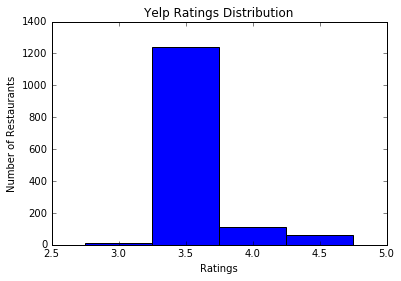

In [85]:
def trainModelToPredictLowReviews(data):
    training = filter(lambda x: x["review_count"] > 10, data)
    predict = filter(lambda x: x["review_count"] <= 10, data)
    (X, y) = transform_to_XY(training)[:2]
    (Xp, yp) = transform_to_XY(predict)[:2]
    pca = PCA(n_components='mle')
    pca.fit(X)
    X = pca.transform(X)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X,y)
    Xp = pca.transform(Xp)
    result = model.predict(Xp)
    return result

results = trainModelToPredictLowReviews(data)
results = Counter(results)
rating_numbers = sorted(results)
rating_counts = []
for i in xrange(len(rating_numbers)):
    rating_counts.append(results[rating_numbers[i]])
for i in xrange(len(rating_numbers)):
    rating_numbers[i] /= 2.0
plt.bar(rating_numbers, rating_counts, 0.5, color="blue", align = "center")
plt.xlabel("Ratings")
plt.ylabel("Number of Restaurants")
plt.title("Yelp Ratings Distribution")
plt.show()

Looking forward, we believe there are a number of things that may be able to improve upon the results we have obtained. Firstly, we think that using some form of NLP and text analytics on the customer reviews of a restaurant would provide valuable incite into the predicted rating of a restaurant. A potential problem with this is that our project is motivated by predicting the ratings of restaurants with few reviews, and this would be a problem if there was insufficient review text to analyze. Additionally, given more time we could collect an even larger data set, as the information from Yelp is (nearly) limitless compared to the subset that we had time to request and deal with. In the future, we think that some more subtle and difficult to collect features could be analyzed such as contents of the images or menus posted by the resaurant. 

## Appendix

In [73]:
def save_pickle(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def authenticate(config_filepath):
    creds = json.load(open(config_filepath))
    auth = Oauth1Authenticator(**creds)
    return Client(auth)

def yelp_search(client, query):
    res = client.search(query)
    return (res.total, res.businesses)

def all_restaurants(client, query, food):
    B = []
    while True:
        try:
            res = client.search(query,**{"category_filter":food,"offset" : len(B)})
            if not res.businesses:
                return B
            B += res.businesses
        except:
            return B

def get_cities_info(client, food, cities):
    d = {}
    for city in cities:
        print "requesting: ", city,
        d["%s_%s"%(city,food)] = all_restaurants(client,city,food)
        print ": done"
    valids = filter(lambda x: len(d[x]) >= 10, d)
    res = {v:d[v] for v in valids}
    return res

def get_all_cities():
    with open("cities.txt",'r') as f:
        lines = map(lambda l: ", ".join(l.rstrip().split("\t")[1:3]),f.readlines())
        return lines
    
def clean_business(b):
    valids = ["categories", "location", "name", "rating", "review_count","url"]
    return {x : b.__dict__[x] for x in valids} 
    
def clean_data(data):
    new_data = {}
    for city in data:
        new_data[city] = map(clean_business, data[city])
    return new_data
    
def get_data():
    client = authenticate("secret.json")
    cities = get_all_cities()
    data = get_cities_info(client, "restaurant", cities)
    data = clean_data(data)
    save_pickle("all_restaurants.pkl", data)
    
#get_data()

def retrieve_html(url):
    html = requests.get(url)
    return (html.status_code, html.content)

""" Gets restaurant features from yelp html given a url for a restaurants page
    returns a dictionary of the available features on the page (keys) with their 
    corresponding values """
def scrapeYelpFeatures(url):
    (yolo, html) = retrieve_html(url)
    
    try:
        imgs =  re.search(r"See all [0-9]+", html).group()
        imgs = [int(s) for s in imgs.split() if s.isdigit()][0]
    except:
        imgs = 0
    root = BeautifulSoup(html, "html.parser")
    s = root.findAll("div", {'class' : 'ywidget'})
    
    biz_features = {"number_of_images" : imgs}
    for i in s:
        h3_elem = i.find("h3")
        if h3_elem != None:
            if 'More business info' in h3_elem:
                biz_attr = i.find('ul', {'class' : 'ylist'}).findAll('dt', {'class' : 'attribute-key'})
                biz_val = i.find('ul', {'class' : 'ylist'}).findAll('dd')

                for (l,r) in zip(biz_attr, biz_val):
                    biz_features[l.next_element.strip()] = r.next_element.strip()
    return biz_features

def add_feature_info(data, offset):
    c = offset+1
    for d in data[offset:]:
        print "%d of %d"%(c,len(data))
        features = scrapeYelpFeatures(d["url"])
        d.update(features)
        c += 1
        
def get_feature_set(datalist):
    features = set()
    for f in datalist:
        features |= set(f)
    return features

def fix_features(datalist):
    features = get_feature_set(datalist)
    for d in datalist:
        for f in features:
            if f not in d:
                d[f] = None

def get_random_data(data, n):
    datalist = []
    for d in data:
        datalist += data[d]
    return random.sample(datalist,n)